In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/05-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/11-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/09-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/07-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/03-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/12-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/13-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/15-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/02-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/10-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/04-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
!pip install -U -t /kaggle/working/ git+https://github.com/Kaggle/learntools.git
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning.ex_tpu import *

  Cloning https://github.com/Kaggle/learntools.git to /tmp/pip-req-build-kzibvr1m
  Running command git clone -q https://github.com/Kaggle/learntools.git /tmp/pip-req-build-kzibvr1m
  Created wheel for learntools: filename=learntools-0.3.4-py3-none-any.whl size=215906 sha256=1ae346e5e4673cc98f49add6d18663d287a84e3dea6c1aa4ebc73dca15753f3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-mzd4ndo_/wheels/dd/d7/6b/0fc758f52767fd281d6dceded6757c6cb5bb90ccd2dbb1de9f
Successfully built learntools
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This is the helper script to accompany the notebooks:
#
# Tutorial: https://www.kaggle.com/ryanholbrook/create-your-first-submission
# Exercise: https://www.kaggle.com/ryanholbrook/exercise-create-your-first-submission
#
# These are the tutorial and exercise notebooks for the Learn lesson
# accompanying the Petals to the Metal competition:
#
# https://www.kaggle.com/c/tpu-getting-started
#
# Many thanks to Martin Görner, the original author of the code in
# this script and in the notebooks.
#
# https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu


# %% [code]
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

# %% [markdown]
# # Competition data access
# 
# In order to train a model on a TPU, we need to store the dataset in Google Cloud Storage (GCS). 
# 
# The code cell below will copy the flowers dataset to a GCS bucket co-located with the TPU.

# %% [code]
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

# %% [markdown]
# # Configuration

# %% [code]
IMAGE_SIZE = [512, 512]                   
EPOCHS = 100
SEED=700
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# %% [markdown]
# # Helper functions
# %% [code]
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# %% [markdown]
# These helper functions construct a data pipeline from the TFRecords

# %% [code] {"_kg_hide-input":true}
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_train_data():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_data(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_data(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# %% [markdown]

# %% [code]
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Tensorflow version 2.2.0
Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [4]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [5]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

# Learning rate

In [6]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [7]:

try:
    tpu=tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'TPU : {tpu.master()}')
except ValueError:
    tpu=None
    
    

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

TPU : grpc://10.0.0.2:8470
REPLICAS:  8


In [8]:
train_data= get_train_data()
val_data= get_validation_data()
test_data= get_test_data()

In [9]:
for name in sorted(CLASSES):
    print(name)

alpine sea holly
anthurium
artichoke
azalea
balloon flower
barberton daisy
bee balm
bird of paradise
bishop of llandaff
black-eyed susan
blackberry lily
blanket flower
bolero deep blue
bougainvillea
bromelia
buttercup
californian poppy
camellia
canna lily
canterbury bells
cape flower
carnation
cautleya spicata
clematis
colt's foot
columbine
common dandelion
common tulip
corn poppy
cosmos
cyclamen 
daffodil
daisy
desert-rose
fire lily
foxglove
frangipani
fritillary
garden phlox
gaura
gazania
geranium
giant white arum lily
globe thistle
globe-flower
grape hyacinth
great masterwort
hard-leaved pocket orchid
hibiscus
hippeastrum 
iris
japanese anemone
king protea
lenten rose
lilac hibiscus
lotus
love in the mist
magnolia
mallow
marigold
mexican petunia
monkshood
moon orchid
morning glory
orange dahlia
osteospermum
passion flower
peruvian lily
petunia
pincushion flower
pink primrose
pink quill
pink-yellow dahlia
poinsettia
primula
prince of wales feathers
purple coneflower
red ginger
rose
r

In [10]:
for image, label in train_data.take(5):
    print("Image shape: ", image.numpy().shape, label.numpy().shape)
print("Train data:", label.numpy())
    
for image, idnum in test_data.take(5):
    print("Test Image: ",image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U'))

Image shape:  (128, 512, 512, 3) (128,)
Image shape:  (128, 512, 512, 3) (128,)
Image shape:  (128, 512, 512, 3) (128,)
Image shape:  (128, 512, 512, 3) (128,)
Image shape:  (128, 512, 512, 3) (128,)
Train data: [ 80 103  50 ...  62   4  53]
Test Image:  (128, 512, 512, 3) (128,)
Test Image:  (128, 512, 512, 3) (128,)
Test Image:  (128, 512, 512, 3) (128,)
Test Image:  (128, 512, 512, 3) (128,)
Test Image:  (128, 512, 512, 3) (128,)
Test data IDs: ['cf1ad8706' 'e44a6c4d1' 'e1b63aee0' ... '7d540187a' '1d24f052a' 'a670f0c43']


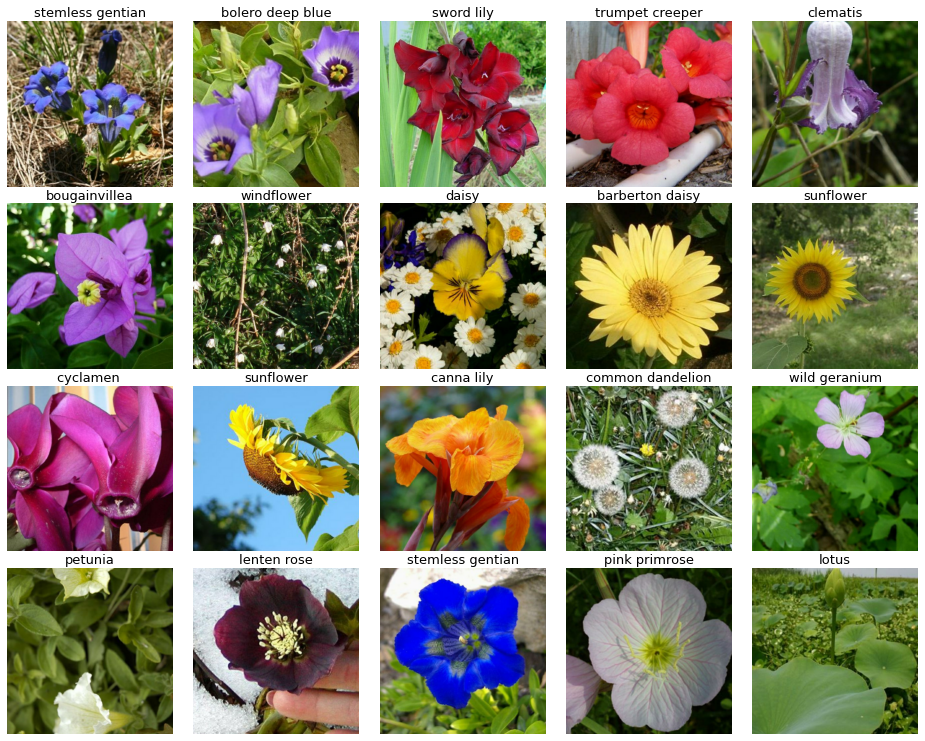

In [11]:
petal_photo= next(iter(train_data.unbatch().batch(20)))
display_batch_of_images(petal_photo)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



# **#DENSENET201**
with strategy.scope():
    pretrained_model = tf.keras.applications.DenseNet201(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model_1= tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model_1.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

model_1.summary()


steps_epoch=NUM_TRAINING_IMAGES//BATCH_SIZE
history = model_1.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    steps_per_epoch=steps_epoch,
)

In [13]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 1.3 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [14]:
import efficientnet.keras as efn 

# EfficientNetB7

In [15]:
with strategy.scope():
    pretrained_model = efn.EfficientNetB7(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model_2= tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model_2.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

model_2.summary()

258441216/258434480 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 266,344
Non-trainable params: 64,097,680
_________________________________________________________________


In [16]:
from sklearn.model_selection import KFold

In [17]:
steps_epoch=NUM_TRAINING_IMAGES//BATCH_SIZE
history = model_2.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    steps_per_epoch=steps_epoch,
)

Epoch 1/100
99/99 [==============================] - 57s 575ms/step - sparse_categorical_accuracy: 0.3206 - loss: 3.1280 - val_sparse_categorical_accuracy: 0.4876 - val_loss: 2.1676
Epoch 2/100
99/99 [==============================] - 31s 317ms/step - sparse_categorical_accuracy: 0.5401 - loss: 2.0490 - val_sparse_categorical_accuracy: 0.6393 - val_loss: 1.5785
Epoch 3/100
99/99 [==============================] - 32s 318ms/step - sparse_categorical_accuracy: 0.6307 - loss: 1.6551 - val_sparse_categorical_accuracy: 0.6926 - val_loss: 1.3101
Epoch 4/100
99/99 [==============================] - 32s 319ms/step - sparse_categorical_accuracy: 0.6711 - loss: 1.4498 - val_sparse_categorical_accuracy: 0.7214 - val_loss: 1.1463
Epoch 5/100
99/99 [==============================] - 32s 319ms/step - sparse_categorical_accuracy: 0.7054 - loss: 1.2914 - val_sparse_categorical_accuracy: 0.7516 - val_loss: 1.0350
Epoch 6/100
99/99 [==============================] - 32s 322ms/step - sparse_categorical_a

# VGG16****
with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model_pre= tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model_pre.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

model_pre.summary()


steps_epoch=NUM_TRAINING_IMAGES//BATCH_SIZE
history = model_pre.fit(
    train_data,
    validation_data=val_data,
    epochs=60,
    steps_per_epoch=steps_epoch,
)

# ResNet50****
with strategy.scope():
    pretrained_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model_pre1= tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model_pre1.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

model_pre1.summary()



steps_epoch=NUM_TRAINING_IMAGES//BATCH_SIZE
history = model_pre1.fit(
    train_data,
    validation_data=val_data,
    epochs=60,
    steps_per_epoch=steps_epoch,
)

# VGG19
with strategy.scope():
    pretrained_model = tf.keras.applications.VGG19(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model_pre2= tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model_pre2.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

model_pre2.summary()

'''steps_epoch=NUM_TRAINING_IMAGES//BATCH_SIZE
history = model_pre2.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    steps_per_epoch=steps_epoch,
)'''

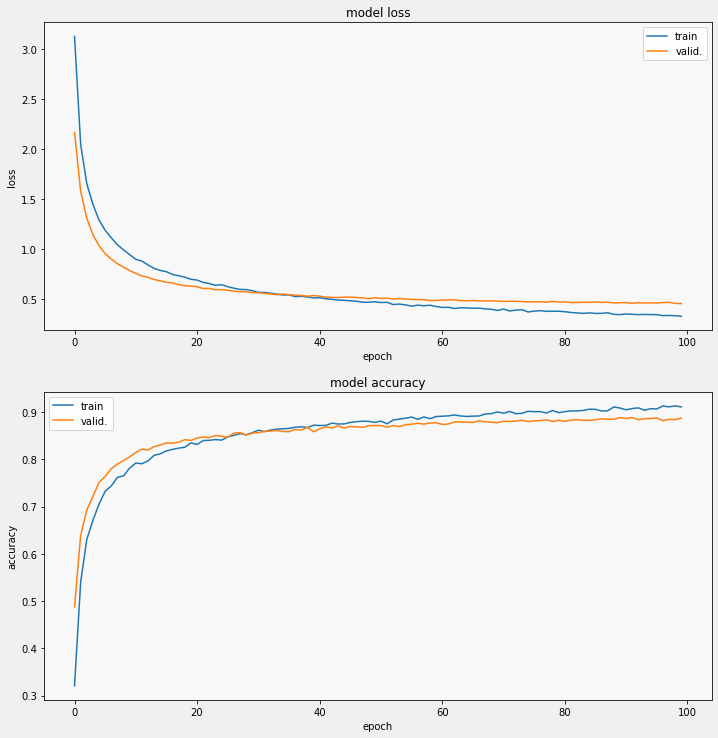

In [18]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)


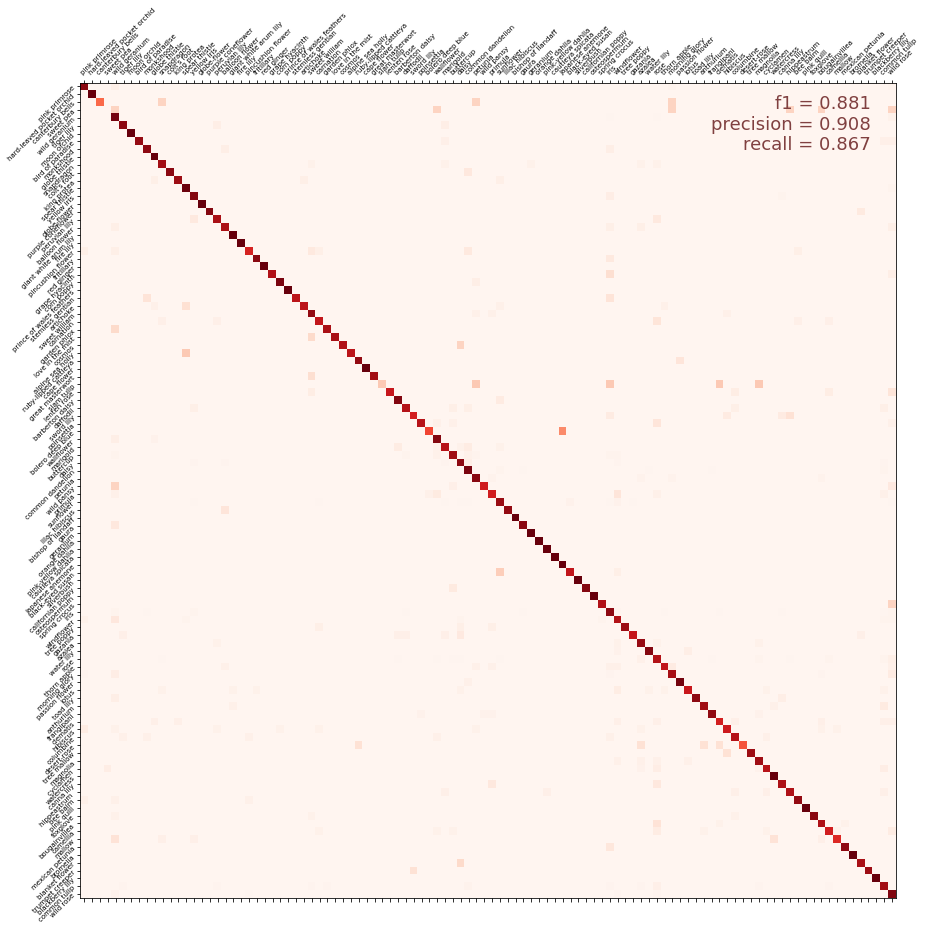

In [19]:
cmdataset = get_validation_data(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model_2.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

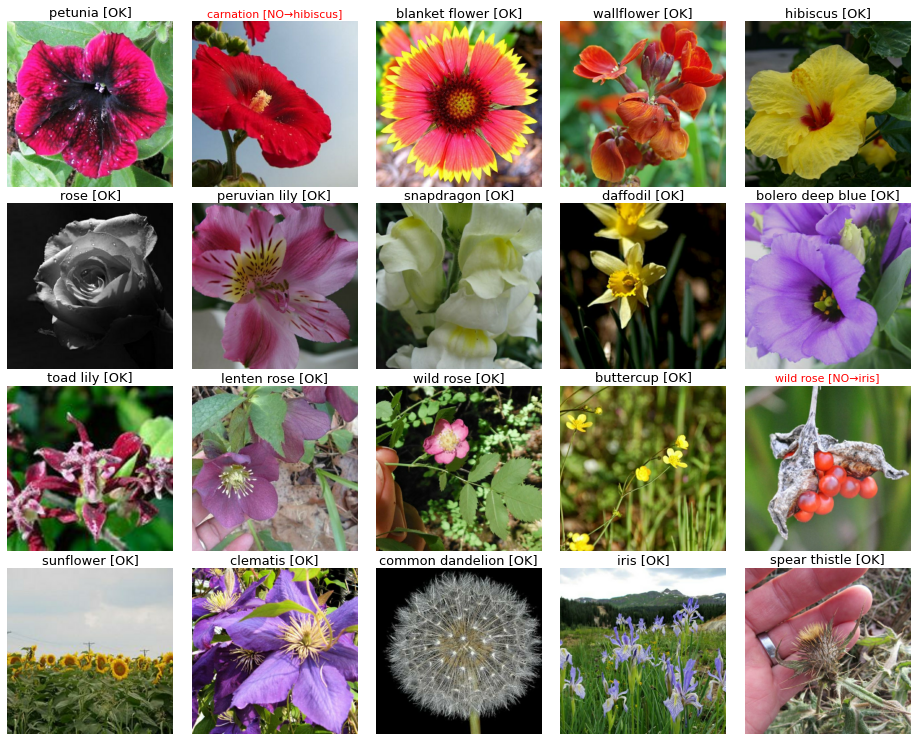

In [20]:
dataset = get_validation_data()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)
images, labels = next(batch)
probabilities = model_2.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [21]:
def train_cross_validate(folds = 5):
    histories = []
    models = []
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
    kfold = KFold(folds, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
        print(); print('#'*25)
        print('### FOLD',f+1)
        print('#'*25)
        train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[trn_ind]['TRAINING_FILENAMES']), labeled = True)
        val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES']), labeled = True, ordered = True)
        #model = get_model()
        history = model.fit(
            get_training_data(train_dataset), 
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = EPOCHS,
            callbacks = [lr_callback],#, early_stopping],
            validation_data = get_validation_data(val_dataset),
            verbose=2
        )
        models.append(model)
        histories.append(history)
    return histories, models



def train_and_predict(folds = 5):
    test_ds = get_test_data(ordered=True) 
    test_images_ds = test_ds.map(lambda image, idnum: image)
    print('Start training %i folds'%folds)
    histories, models = train_cross_validate(folds = folds)
    print('Computing predictions...')
    # get the mean probability of the folds models
    probabilities = np.average([models[i].predict(test_images_ds) for i in range(folds)], axis = 0)
    predictions = np.argmax(probabilities, axis=-1)
    print('Generating submission.csv file...')
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
    np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    return histories, models
    
# run train and predict
histories, models = train_and_predict(folds = FOLDS)

In [22]:
test_ds = get_test_data(ordered=True)

print('Computing predictions...')
#histories, models = train_cross_validate(folds = folds)
test_images_ds = test_ds.map(lambda image, idnum: image)
#probabilities = np.average([models[i].predict(test_images_ds) for i in range(folds)], axis = 0)
#predictions = np.argmax(probabilities, axis=-1)
probabilities = model_2.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[ 67  28  83 ...  77 102  62]


In [23]:


# Get image ids from test set and convert to integers
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

In [24]:
sub= pd.read_csv('submission.csv')
sub

,id,label
0,252d840db,67
1,1c4736dea,28
2,c37a6f3e9,83
3,00e4f514e,103
4,59d1b6146,70
...,...,...
7377,c785abe6f,7
7378,9b9c0e574,68
7379,e46998f4d,77
7380,523df966b,102
